# Quantum Approximate Optimization Algorithm (QAOA): MaxCut Problem

This notebook demonstrates the QAOA algorithm using Classiq. It covers the Max-Cut problem as an example of a combinatorial optimization problem, showcasing how QAOA can be applied to graph-based optimization tasks [[1](#QAOA)].

## Introduction

### The Max-Cut Problem

Given an undirected graph $G = (V, E)$, the goal is to partition the vertices into two sets **to maximize the number of edges between the sets**. In this context, an edge between is "cut" **if its endpoints belong to different sets**. The standard formulation is:

**Input:**  
- $G = (V, E)$: A graph with vertices $V$ and edges $E$.

**Output:**  
- A partition $S, \bar{S}$ that maximizes the cut value:
$$
f_{obj}(x)=\max_{S \subset V} \sum_{(i,j) \in E} \left(1 - \delta_{s_i, s_j}\right)
$$
where $s_i$ indicates the subset assignment for vertex $i$, and $\delta_{s_i, s_j}$ is the Kronecker delta function.

The Max-Cut problem is known to be $\mathsf{NP}$-complete.

**Note:** A weighted version exists, where each edge has a weight $w_{ij}$, and the goal is to maximize the weighted sum of cut edges.


### Set a Specific Problem Instance to Optimize

We choose a small toy Max-Cut instance using a **5-node graph**:
- **Vertices:** $V = \{0,1,2,3,4\}$
- **Edges:** $E = \{(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)\}$

#### Optimal Max-Cut Solutions
Several partitions achieve the maximum cut value (cutting 5 out of 6 edges). For example:

**Option 1:**  
- **Set 1:** $\{0,2,3\}$
- **Set 2:** $\{1,4\}$

**Option 2:**  
- **Set 1:** $\{2,3\}$
- **Set 2:** $\{0,1,4\}$

Both options represent optimal solutions for this graph, showcasing the non-uniqueness of the optimal partition in a non-trivial Max-Cut instance.


## Algorithm Description

In this problem, we apply quantum transformations to optimize the Max-Cut objective function. A quantum state $|x\rangle$ represents a candidate partition of the graph. The QAOA algorithm comprises two key layers:

1. **Objective Phase (Analog):**  
   A phase rotation in the $Z$-direction is applied based on the objective function:
   $$
   |x\rangle \xrightarrow{U_{\text{o}}(\theta)} e^{i\gamma f_{\text{obj}}(x)} |x\rangle,
   $$
   which encodes the cost associated with a given partition.

2. **Mixing Operator (Digital):**  
   An $X$-rotation is applied to all qubits to explore the solution space:
   $$
   U_B(\beta) = e^{-i\beta H_B}, \quad \text{with } H_B = \sum_i X_i.
   $$
   This promotes transitions between different partitions.

By alternating these layers, the QAOA ansatz iteratively refines the quantum state toward a partition that maximizes the number of cut edges.


## Algorithm Implementation using Classiq

The implementation follows a modular design:

- **Cost Function:**  
  The function `maxcut_cost` computes the normalized negative number of cut edges for a given partition.

- **Cost Layer:**  
  The quantum function `maxcut_cost_layer` uses the `phase` statement to encode this cost into the quantum state, with the parameter $\gamma$ controlling the phase rotation.

- **Mixer Layer:**  
  The function `mixer_layer` applies uniform $RX$ rotations (with parameter $\beta$) to all qubits.

- **QAOA Ansatz:**  
  The overall circuit is constructed by first preparing a uniform superposition (via a Hadamard transform) and then alternating the cost and mixer layers for a specified number of layers.


### Define the MaxCut problem

The implementation we are following is general, but to demonstrate it properly, you will use the specific problem described above. We begin by declaring the nodes and edges of the graph:

In [1]:
from classiq import *

graph_nodes = [0, 1, 2, 3, 4]
graph_edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

Visualizing the above-defined graph:

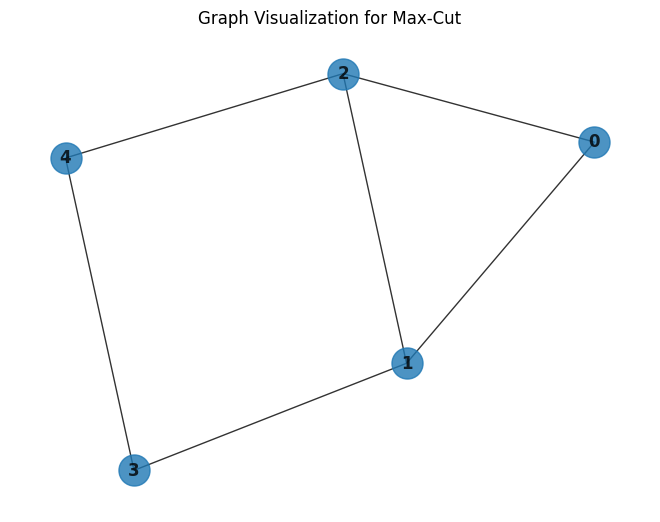

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph instance
G = nx.Graph()
G.add_nodes_from(graph_nodes)
G.add_edges_from(graph_edges)

# Use a layout for better visualization
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, font_weight="bold")
plt.title("Graph Visualization for Max-Cut")
plt.show()

### Algorithms Building Blocks

#### The Cost Layer

The function `maxcut_cost` computes the normalized, negative cost of a partition represented by the quantum state `v`. This means that instead of using the conventional objective function:

$$
f(x) = \sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right),
$$

we use in this implementation:

$$
\text{maxcut\_cost}(x) = -\frac{1}{|E|}\sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right).
$$

This modification serves two purposes:

- **Normalization:** Dividing by the number of edges $|E|$ scales the cost to a consistent range, making it easier to compare across different graphs.
- **Negation for Minimization:** By negating the sum, we can employ minimization algorithms to effectively maximize the number of cut edges.

An inner function, `edge_cut`, determines whether an edge is "cut" (i.e., its endpoints are in different sets), returning 1 if the edge is cut and 0 otherwise.

*Note:* This function is not decorated with `@qfunc` because it is used as an operator within another quantum function.

Below is the implementation:


In [3]:
def maxcut_cost(v: QArray[QBit] | list[int]):
    def edge_cut(n1_bit, n2_bit):
        return n1_bit * (1 - n2_bit) + n2_bit * (1 - n1_bit)

    return -sum(edge_cut(v[node1], v[node2]) for (node1, node2) in graph_edges) / len(
        graph_edges
    )

The following quantum function, `maxcut_cost_layer`, uses the `phase` operation to encode the computed cost into the phase of the quantum state. The parameter `gamma` controls the strength of this phase rotation.

In [4]:
@qfunc
def maxcut_cost_layer(gamma: CReal, v: QArray[QBit]):
    phase(-maxcut_cost(v), gamma)

#### The Mixer Layer

The next main building block is the **mixer layer**. This layer is responsible for exploring the solution space by applying RX rotations to all qubits. By "mixing" the amplitudes between different basis states, the mixer layer prevents the algorithm from getting stuck in local minima and allows the quantum state to transition between different candidate solutions.

Below, the `mixer_layer` is implemented as a quantum function that applies an RX rotation (parameterized by β) to each qubit in the array.

In [5]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(beta, q), qba)

#### The QAOA Ansatz

The overall QAOA ansatz alternates between two layers for a specified number of iterations:
- The **cost layer** encodes the problem’s objective into the quantum state.
- The **mixer layer** promotes transitions between different candidate solutions.

The ansatz operates on a uniform superposition state (prepared in the `main` function) by repeatedly applying these two layers.

In [6]:
@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray[QBit]],
    num_layers: CInt,
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray[QBit],
):
    repeat(
        num_layers,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

## Assemble to the full QAOA algorithm

As in vanilla QAOA, the quantum program first applies a `hadamard_transform()` to prepare the qubits in a uniform superposition. After this initial state preparation, the circuit sequentially applies the cost and mixer layers, each with their own parameters that are updated by the classical optimization loop as we will show in the next section.

In [7]:
NUM_LAYERS = 4


@qfunc
def main(
    params: CArray[CReal, NUM_LAYERS * 2],
    v: Output[QArray[QBit, len(graph_nodes)]],
):
    allocate(v.size, v)
    hadamard_transform(v)  # here or aside?
    qaoa_ansatz(
        maxcut_cost_layer,
        NUM_LAYERS,
        params[0:NUM_LAYERS],
        params[NUM_LAYERS : 2 * NUM_LAYERS],
        v,
    )

Having defined the `main` function, now you can create the model, synthesize it, and display the resulting quantum program. Note that this synthesized program is not yet executable since we haven't specified any parameter set.

In [8]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2tWtmUKfuosyLYgdccAi5Jj5A2g?version=0.69.0


## Classical Optimization

We have constructed a parameterized QAOA circuit for the Max-Cut problem. The circuit accepts a parameter array of size $NUM\_LAYERS \times 2$, with the first half corresponding to the cost layer parameters (gammas) and the second half to the mixer layer parameters (betas).

We execute the circuit using an `ExecutionSession` configured to sample a fixed number of shots ($NUM\_SHOTS$) per evaluation. The method `ExecutionSession.estimate_cost` computes the cost for a given parameter set using the same `maxcut_cost` function embedded in the cost layer.

For classical optimization, we use `scipy.optimize.minimize` with the COBYLA method. The optimizer repeatedly calls our evaluation function to minimize the cost—thus maximizing the cut value.

Below is the code implementing the classical optimization loop:

In [9]:
import math

import numpy as np
import scipy

from classiq.execution import ExecutionSession
from classiq.interface.executor.execution_preferences import ExecutionPreferences

NUM_SHOTS = 1000

with ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
) as es:
    cost_func = lambda state: maxcut_cost(state["v"])

    initial_params = (
        np.concatenate((np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS)))
        * math.pi
    )
    final_params = scipy.optimize.minimize(
        lambda params: es.estimate_cost(
            lambda state: maxcut_cost(state["v"]),
            {"params": params.tolist()},
        ),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": 60},
    ).x.tolist()
    res = es.sample({"params": final_params})

## Displaying and Discussing the Results

After optimization, we print the optimized parameters and display the measurement outcomes. Each measurement outcome is a bitstring representing a partition of the graph's vertices. The associated probability is the fraction of shots in which that partition was observed, and the cost (computed by `maxcut_cost`) indicates the performance of the partition (with a lower, more negative cost indicating a better solution).

For example, a solution with a cost of $-0.833$ means that 5 out of 6 edges are cut ($5/6 = 0.833$), which is optimal for this instance.


In [11]:
print(f"Optimized parameters: {final_params}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: maxcut_cost(pc.state["v"]))
for sampled in sorted_counts:
    solution = sampled.state["v"]
    probability = sampled.shots / NUM_SHOTS
    cost_value = maxcut_cost(sampled.state["v"])
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [0.8558716093302701, 2.230533787155444, 1.4988675843844288, 3.023120199009894, 2.315670663960166, -0.06836551385661592, 2.6762317382161505, -0.37852739761712334]
solution=[1, 1, 0, 0, 1] probability=0.154 cost=-0.833
solution=[1, 0, 1, 1, 0] probability=0.149 cost=-0.833
solution=[0, 1, 0, 0, 1] probability=0.143 cost=-0.833
solution=[0, 0, 1, 1, 0] probability=0.136 cost=-0.833
solution=[0, 1, 1, 0, 0] probability=0.065 cost=-0.667
solution=[1, 0, 0, 1, 1] probability=0.061 cost=-0.667
solution=[0, 1, 1, 1, 0] probability=0.047 cost=-0.667
solution=[0, 1, 1, 0, 1] probability=0.045 cost=-0.667
solution=[1, 0, 0, 0, 1] probability=0.041 cost=-0.667
solution=[1, 0, 0, 1, 0] probability=0.035 cost=-0.667
solution=[1, 1, 0, 1, 0] probability=0.019 cost=-0.500
solution=[0, 0, 1, 0, 1] probability=0.015 cost=-0.500
solution=[0, 0, 1, 0, 0] probability=0.011 cost=-0.500
solution=[0, 1, 0, 0, 0] probability=0.010 cost=-0.500
solution=[0, 1, 0, 1, 0] probability=0.008 cos

So, `solution=[1, 1, 0, 0, 1]` means that vertices 0, 1, and 4 are assigned to one set, while vertices 2 and 3 form the other set. This solution appears with a probability of 0.154 and has a cost of -0.833, indicating that 5 out of the 6 edges are cut—an optimal configuration for our instance.

Overall, the QAOA circuit predominantly produces optimal partitions with a normalized cost of approximately -0.833, indicating that 5 out of the 6 edges are cut."

## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)